This version splits by record and removes identifiable birth information because they do not change as the baby grows. but still overfitting. jaundice is still leading but it is at least spread out to more variables. also uses predict proba

In [96]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imb_pipeline
from imblearn.over_sampling import SMOTENC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# <div style="background-color:#00357A; padding:20px; border-radius:10px; color:white; width:auto;">Proposed Method</div>

## <div style="background-color:#0081CC; padding:10px; border-radius:10px; color:white; width:auto;">Loading Files</div>

In [12]:
# load the data frame
df = pd.read_csv('historical.csv')
fn_details = pd.read_csv('corrected_false_negatives.csv')

In [13]:
df.iloc[:,9:]

,weight_kg,length_cm,head_circumference_cm,temperature_c,heart_rate_bpm,respiratory_rate_bpm,oxygen_saturation,feeding_type,feeding_frequency_per_day,urine_output_count,stool_count,jaundice_level_mg_dl,apgar_score,immunizations_done,reflexes_normal,risk_level
0,3.28,50.1,32.0,37.0,160,36,98,Formula,11,9,0,4.2,7.0,Yes,Yes,At Risk
1,3.35,50.2,32.0,37.2,156,40,99,Formula,11,5,2,10.6,NaN,No,No,At Risk
2,3.35,50.6,32.1,37.1,137,37,97,Breastfeeding,7,6,5,9.8,NaN,No,No,Healthy
3,3.48,50.3,32.0,37.4,130,33,97,Mixed,11,8,4,8.1,NaN,No,Yes,Healthy
4,3.50,50.3,31.8,36.8,138,39,96,Breastfeeding,11,7,1,11.6,NaN,No,Yes,At Risk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,4.99,52.5,34.8,37.1,141,36,98,Mixed,8,8,2,2.5,NaN,No,Yes,Healthy
2096,5.04,52.6,34.6,36.8,138,34,98,Mixed,7,8,4,3.3,NaN,No,Yes,Healthy
2097,5.05,52.9,34.9,37.3,131,46,97,Mixed,11,6,2,3.2,NaN,No,Yes,Healthy
2098,5.03,52.9,34.8,37.0,133,45,98,Mixed,10,5,5,3.2,NaN,No,Yes,Healthy


In [14]:
# get complete columns for false negative babies
fn_df = fn_details.merge(df, 
                         on=fn_details.columns.tolist(), 
                         how='left')

In [15]:
# ----------- STEP 1: Define Feature Types -----------
# Forward fill missing values
df['apgar_score'] = df['apgar_score'].ffill()

# Sepeparate features by data types
numerical_features = ['age_days', 'weight_kg', 'length_cm',
                     'head_circumference_cm', 'temperature_c', 'heart_rate_bpm', 'respiratory_rate_bpm',
                     'oxygen_saturation', 'feeding_frequency_per_day','urine_output_count','stool_count',
                     'jaundice_level_mg_dl']

categorical_features = ['feeding_type']

binary_features = ['gender','immunizations_done', 'reflexes_normal']
for col in binary_features:
    df[col] = (
        df[col]
        .astype(str)
        .str.lower()
        .map({'yes': 1, 'male': 1, 'no': 0, 'female': 0})
        .fillna(0)
        .astype(int)  # ensure numeric dtype
    )
    
drop_col = ['baby_id', 'name', 'date', 'gestational_age_weeks', 'birth_weight_kg', 'birth_length_cm',
                     'birth_length_cm', 'birth_head_circumference_cm', 'apgar_score']
target = df['risk_level']

In [16]:
# ----------- STEP 2: Define Features and Target -----------
X = df.drop(columns='risk_level')
X = X.drop(columns=drop_col)
y = target.replace({'Healthy': 0, 'At Risk': 1}).values

X_Train, X_test, y_Train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=target
)

X_train, X_val, y_train, y_val = train_test_split(
    X_Train, y_Train, test_size=0.2, random_state=0, stratify=y_Train
)

In [20]:
# ----------- STEP 3: Preprocessing Pipeline -----------

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(), categorical_features),
        ('bin', 'passthrough', binary_features)  # binary features are left untouched
    ]
)

# Fit preprocessor to get feature names
preprocessor.fit(X_train)
feature_names_out = preprocessor.get_feature_names_out()

numerical_count = len(numerical_features)
new_categorical_features = preprocessor.named_transformers_['cat']
categorical_count = len(new_categorical_features.get_feature_names_out())
binary_count = len(binary_features)

indices = list(range(numerical_count, numerical_count + categorical_count + binary_count))

# Parameter grids for hyperparameter tuning
params = {
    'Random Forest': {
        'smote__k_neighbors': [3, 5, 7],
        'clf__n_estimators': [100, 200, 300],
        'clf__max_depth': [5, 7, 9, None],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4]
    },
    'Gradient Boosting': {
        'smote__k_neighbors': [3, 5, 7],
        'clf__n_estimators': [100, 200, 300],
        'clf__max_depth': [3, 5, 7],
        'clf__learning_rate': [0.01, 0.05, 0.1]
    }
}

models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(loss="log_loss", random_state=42)
}

In [24]:
results = []
trained_models = {}

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training: {name}")
    print(f"{'='*60}")
    
    pipe = imb_pipeline([
        ("preprocessor", preprocessor),
        ("smote", SMOTENC(categorical_features=indices,
                          random_state=42)),
        ("clf", model)
        
    ])

    rcv = RandomizedSearchCV(pipe, params[name], 
                             random_state=0, scoring='f1', cv=kfold)
    search = rcv.fit(X_train, y_train)
    
    best_params = search.best_params_
    best_model = search.best_estimator_
    print(best_params)
    trained_models[name] = best_model
    
    y_train_pred = best_model.predict(X_train)
    y_val_pred = best_model.predict(X_val)
    y_test_pred = best_model.predict(X_test)
    
    y_train_proba = best_model.predict_proba(X_train)[:, 1]
    y_val_proba = best_model.predict_proba(X_val)[:, 1]
    y_test_proba = best_model.predict_proba(X_test)[:, 1]
    print("Prediction")
    #print(best_model.predict_proba(X_train))
    #print(best_model.predict_proba(X_val))
    #print(best_model.predict_proba(X_test))

    # Compute scores
    train_acc_scores.append(accuracy_score(y_train, y_train_pred))
    test_acc_scores.append(accuracy_score(y_test, y_test_pred))
    prec_scores.append(precision_score(y_test, y_test_pred))
    rec_scores.append(recall_score(y_test, y_test_pred))
    
    results.append({
        'Model': name,
        'Train_Acc': accuracy_score(y_train, y_train_pred),
        'Val_Acc': accuracy_score(y_val, y_val_pred),
        'Test_Acc': accuracy_score(y_test, y_test_pred),
        'Train_F1': f1_score(y_train, y_train_pred),
        'Val_F1': f1_score(y_val, y_val_pred),
        'Test_F1': f1_score(y_test, y_test_pred),
        'Train_Precision': precision_score(y_train, y_train_pred),
        'Val_Precision': precision_score(y_val, y_val_pred),
        'Test_Precision': precision_score(y_test, y_test_pred),
        'Train_Recall': recall_score(y_train, y_train_pred),
        'Val_Recall': recall_score(y_val, y_val_pred),
        'Test_Recall': recall_score(y_test, y_test_pred),
    })

# ----------- STEP 6: Show Results -----------

results_df = pd.DataFrame(results).sort_values(by='Test_F1', ascending=False).reset_index(drop=True)
print(results_df)


Training: Random Forest
{'smote__k_neighbors': 5, 'clf__n_estimators': 300, 'clf__min_samples_split': 10, 'clf__min_samples_leaf': 2, 'clf__max_depth': None}
Prediction

Training: Gradient Boosting
{'smote__k_neighbors': 5, 'clf__n_estimators': 200, 'clf__max_depth': 5, 'clf__learning_rate': 0.01}
Prediction
               Model  Train_Acc  Val_Acc  Test_Acc  Train_F1  Val_F1  Test_F1  \
0      Random Forest        1.0      1.0  1.000000       1.0     1.0  1.00000   
1  Gradient Boosting        1.0      1.0  0.997619       1.0     1.0  0.99115   

   Train_Precision  Val_Precision  Test_Precision  Train_Recall  Val_Recall  \
0              1.0            1.0        1.000000           1.0         1.0   
1              1.0            1.0        0.982456           1.0         1.0   

   Test_Recall  
0          1.0  
1          1.0  


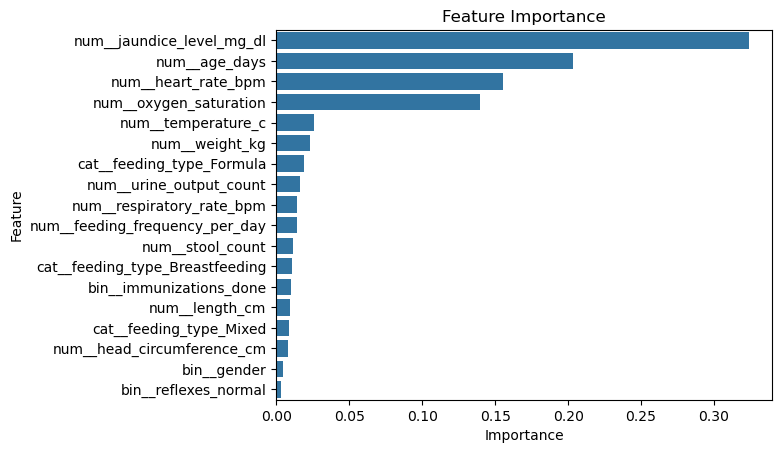

In [28]:
rf_model = RandomForestClassifier(random_state=42, 
                                  n_estimators=300, max_depth=None,
                                  min_samples_leaf=2, min_samples_split=10)

best_pipe = imb_pipeline([
        ("preprocessor", preprocessor),
        ("sample", SMOTENC(categorical_features=indices,
                           k_neighbors = 5,
                          random_state=42)),
        ("clf", rf_model)
    ])

best_pipe.fit(X_train, y_train)

FEATURE_NAMES_NEW = preprocessor.get_feature_names_out()
feature_importances = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': FEATURE_NAMES_NEW,
    'Importance': feature_importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

In [29]:
y_train_pred = best_pipe.predict(X_train)
y_test_pred = best_pipe.predict(X_test)
print(classification_report(y_test, y_test_pred))
print(pd.DataFrame(confusion_matrix(y_test, y_test_pred)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        56

    accuracy                           1.00       420
   macro avg       1.00      1.00      1.00       420
weighted avg       1.00      1.00      1.00       420

     0   1
0  364   0
1    0  56
